In [2]:
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff 
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import *
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
%matplotlib inline
np.random.seed(42)

### Loading toy train time series

Below is a time series showing the gyro_yaw of the toy train. Please notice that the gyro_yaw is dependent to other parameters besides time. However, for simplicity, I ignored that. I can assess it in the next step.
Like considering exogenous inputs. That means we model the time series using other independent variables as well as time series itself. this is like a combination between an ARMA model and a nomal linear reg model.


In [3]:
raw_data = loadarff('toy-train.arff')
df_data = pd.DataFrame(raw_data[0])

In [4]:
print(df_data.shape)

(2335, 6)


In [5]:
print(df_data.sample(5))

      temperature  pressure  humidity  gyro_pitch  gyro_roll  gyro_yaw
2035        40.50   1017.39     20.83        4.51       1.28    345.43
1724        40.35   1017.38     20.90        2.42       1.95    282.44
2176        40.78   1017.35     21.95        2.64       1.44    198.08
915         40.07   1017.36     20.87        2.00       1.95    261.87
2025        40.54   1017.40     21.68        6.63       1.83    344.44


## Identification Step
In the identification step, I explore and characterize the data to find the appropriate model.
It includes:
<br>
- Is the time series stationary?
- what differencing and transforms make it startionary?
- Is the time series seasonal or non-seasonal? If it is seasonal, then what is the seasonal period?
- what order values are the most promising?
<br>

Box-Jnksin method: BJ method is a kind of checklist for us to go from raw data to a model ready for production. the steps between us and prodcution including identification, estimation, model diagnostic, model ok? y: production N: rework.

#### Seasonality test
I visualize data for seasonality. From the time series plot, we can see sesonal pattern.  

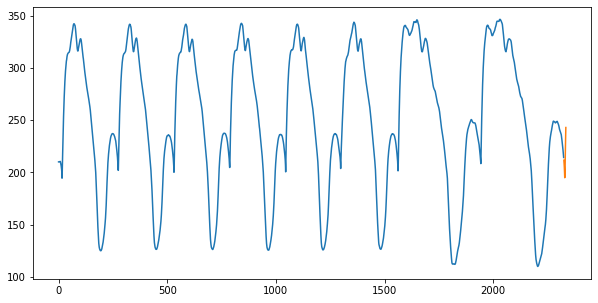

In [6]:
# Split the data into a train and test set

train = df_data['gyro_yaw'][0:-10]
test = df_data['gyro_yaw'][-10:]

# Create an axis
fig, ax = plt.subplots(figsize=(10,5))

# Plot the train and test sets on the axis ax
train.plot(ax=ax)
test.plot(ax=ax)
plt.show()

#### Multiplicative seasonality test
Here, we investigate the seasonality type and trend. Below, residual of additive decomposition still showing some trend. Hence it is considered as multiplicative residual data. In this type, the amplitude of our seasonality becomes larger or smaller based on the trend. 
<br>
multiplicative series = trend*season

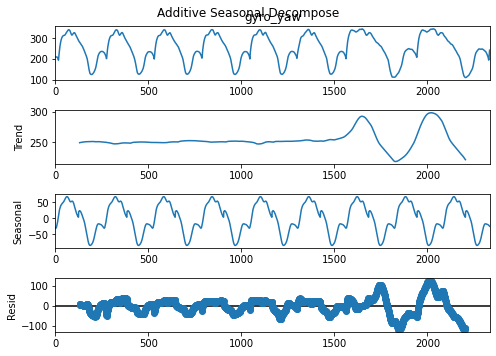

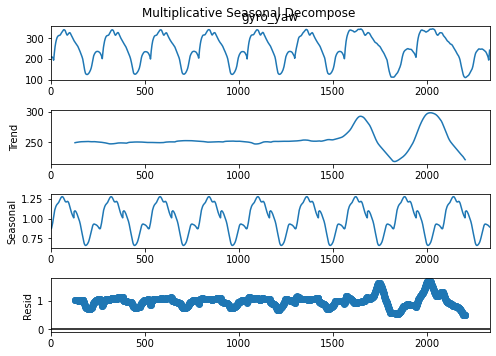

In [7]:

ts=df_data['gyro_yaw']
p=260
# additive decomposition
result_additive = seasonal_decompose(ts,model='additive',period=p)

# multiplicative
result_multiplicative = seasonal_decompose(ts,model='multiplicative',period=p)

# plot
plt.rcParams.update({'figure.figsize':(7,5)})
result_additive.plot()
plt.suptitle('Additive Seasonal Decompose', fontsize=12)
plt.show()

result_multiplicative.plot()
plt.suptitle('Multiplicative Seasonal Decompose', fontsize=12)
plt.show()

#### Finding seasonal period using ACF
By eye it is hard to detect the period of the obvious seasonal pattern. So, I will use the ACF to test this data for seasonality. I found the period of 260.

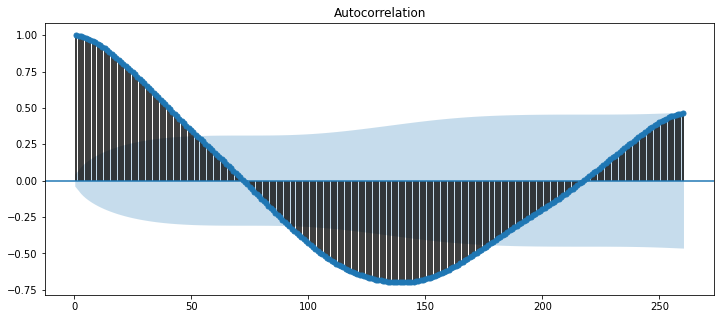

In [8]:
# Create figure and subplots
fig, ax1 = plt.subplots(figsize=(12,5))

# Plot the ACF
tsaplots.plot_acf(df_data['gyro_yaw'], lags=260, zero=False, ax=ax1)

# Show figure
plt.show()

#### Stationary test

The time series is stationary when it has constant variance and autocorrelation with no growing and shrinking ternd.
For the time series, as we can see in the below and up figures, there is no constant variance and autocorrelation.
Please note that in the seasonal time series, Augmented Dickey Fuller test is not showing non-stationary. Because adfuller assumes data is AR(p) and non-stationary. if p-valuse is less than 0.05 means that the time series is stationary.

In [9]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(260).mean() 
    rolstd = timeseries.rolling(260).std()
    #Plot rolling statistics
    plt.figure(figsize=(12,5))
    orig = plt.plot(timeseries, color='black', label='Original')
    mean = plt.plot(rolmean, color='yellow', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label='Rolling Std')
    plt.legend(loc='best', fontsize='large')
    plt.title('Rolling Mean & Standard Deviation', size=15)
    plt.show(block=False)
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries)
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in result[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput[1] <= 0.05:
        print('Strong evidence against null hypothesis. Hence reject the null hypothesis. Data is stationary')
    else:
        print('weak evidence against null hypothesis. Hence we cannot reject null hypothesis. Data is non-stationary')

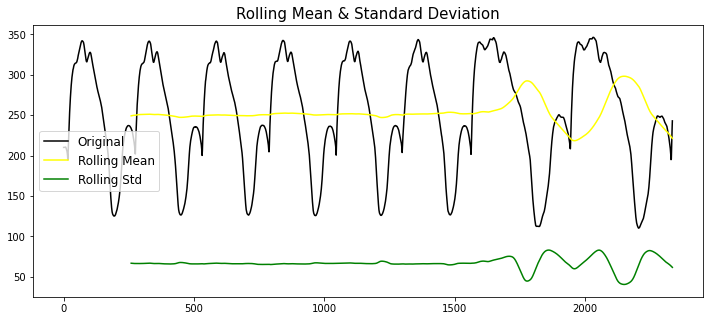

Results of Dickey-Fuller Test:
Test Statistic                   -4.774630
p-value                           0.000061
#Lags Used                        3.000000
Number of Observations Used    2331.000000
Critical Value (1%)              -3.433158
Critical Value (5%)              -2.862781
Critical Value (10%)             -2.567430
dtype: float64
Strong evidence against null hypothesis. Hence reject the null hypothesis. Data is stationary


In [10]:
test_stationarity(df_data['gyro_yaw'])

#### Making the time series stationary (log transform)

Since the time series is multiplicative, and the amplitude of the oscillation get larger as the data trends uo or smaller as it trends dwon. To deal with this, I take the log transform of the data befire modeling it. 

In [11]:

df_data_log = np.log(df_data['gyro_yaw'])


#### Differencing orders

Since the time series has a strong seasonality, I use the seasonal differencing. I tested different differencing for seasonal and non-seasonal ones. Finally I found d=1 and D=1 the best one that amost pass the stationary test as follows:


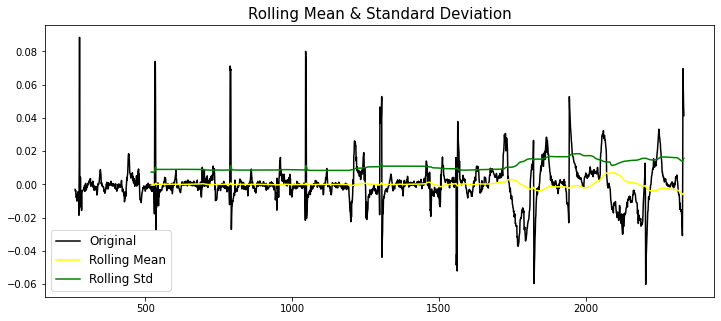

Results of Dickey-Fuller Test:
Test Statistic                -8.914644e+00
p-value                        1.080944e-14
#Lags Used                     7.000000e+00
Number of Observations Used    2.066000e+03
Critical Value (1%)           -3.433519e+00
Critical Value (5%)           -2.862940e+00
Critical Value (10%)          -2.567515e+00
dtype: float64
Strong evidence against null hypothesis. Hence reject the null hypothesis. Data is stationary


In [32]:
# Take the first and seasonal differences and drop NaNs
df_diff = df_data_log.diff().diff(260).dropna() #
test_stationarity(df_diff)

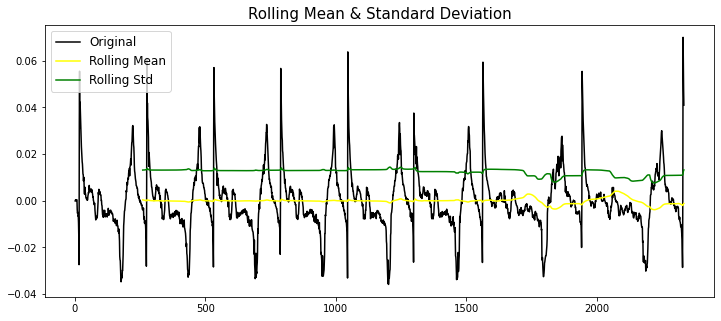

Results of Dickey-Fuller Test:
Test Statistic                -8.600712e+00
p-value                        6.881259e-14
#Lags Used                     2.000000e+00
Number of Observations Used    2.331000e+03
Critical Value (1%)           -3.433158e+00
Critical Value (5%)           -2.862781e+00
Critical Value (10%)          -2.567430e+00
dtype: float64
Strong evidence against null hypothesis. Hence reject the null hypothesis. Data is stationary


In [33]:
# Take the first and seasonal differences and drop NaNs
df_diff2 = df_data_log.diff().dropna() #
test_stationarity(df_diff2)

The following plot shows that the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quickly, which indicates, the series might have been over differenced. Therefore, I will go for first order differencing.

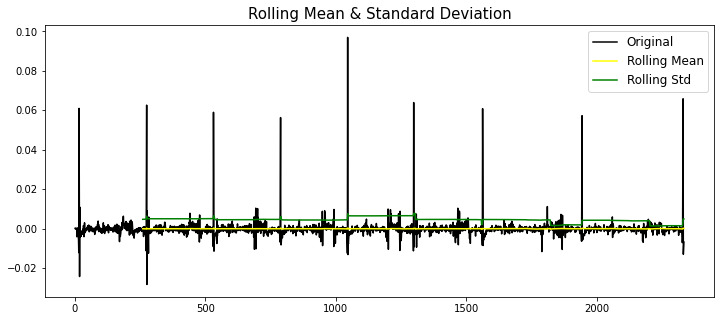

Results of Dickey-Fuller Test:
Test Statistic                  -30.863690
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    2330.000000
Critical Value (1%)              -3.433160
Critical Value (5%)              -2.862781
Critical Value (10%)             -2.567431
dtype: float64
Strong evidence against null hypothesis. Hence reject the null hypothesis. Data is stationary


In [49]:
# Take the first and seasonal differences and drop NaNs
df_diff2 = df_data_log.diff().diff().dropna() #
test_stationarity(df_diff2)

### Choosing SARIMA order

In this part, we will find the appropriate model order. The test statistic and p-value above show no a large difference between the seasonal difference with period of 260 and normal difference. So for simplicity, I will go for normal diferencing.
I will create non-seasonal ACF and PACF plots and use the table below to choose the appropriate model orders.


                   AR(p)	                    MA(q)	            ARMA(p,q)
     
     ACF	     Tails off	             Cuts off after lag q    	Tails off
     PACF   	Cuts off after lag p	  Tails off          	    Tails off

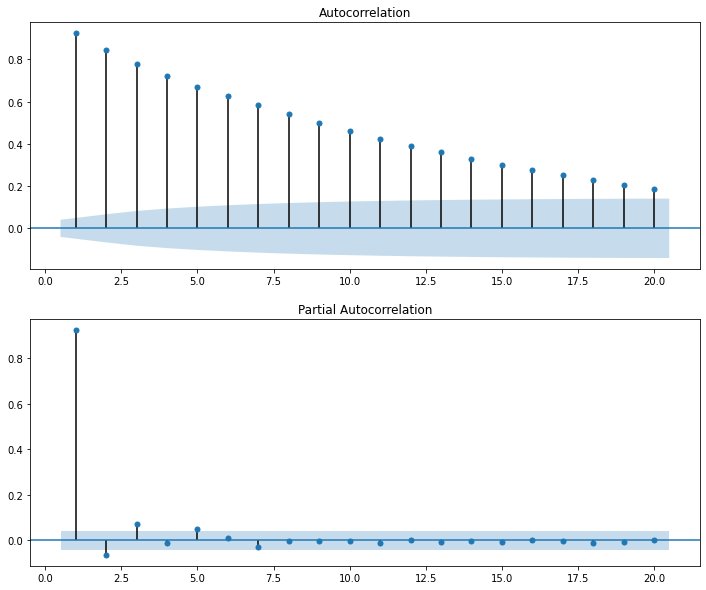

In [51]:
# non-seasonal model orders (p,q) 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,10))
# Plot the ACF on ax1
plot_acf(df_data_log.diff().dropna(), lags=20, zero=False, ax=ax1)

# Plot the PACF on ax2
plot_pacf(df_data_log.diff().dropna(), lags=20, zero=False, ax=ax2)

plt.show()

#### Search over model orders

We can use the auto_arima pkg to make the search automated as follows. However, for simplicity and saving time, I used ACF and PACF to determine the model orders, i.e. p=1, q=0.

In [ ]:
# Import pmdarima as pm
import pmdarima as pm

# Create model for SARIMAX(p,1,q)(P,1,Q)260
model = pm.auto_arima(df_data_log,
                      seasonal=True, m=260,
                      d=1, D=1, 
                      start_p=0, start_q=0,
                      max_p=2, max_q=2,
                      start_P=0, start_Q=0,
                      max_P=2, max_Q=2,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True) 

# Print model summary
print(model.summary())

Performing stepwise search to minimize aic


## Estimation

In this step, we estimate the AR and MA coefficients using fit method.
<br>
prob(Q) is the p-valuse associated with the null hypothesis that residuals have no corr structure.
<br>
prob(jB) is p-valuse for null hypothesis that residual are normal or gaussian normally distributed.
<br>
if either is less than 0.05, er reject the hypothesis.

In [ ]:
# Create model object
model = SARIMAX(df_data_log.values, 
                order=(1, 1, 0),  
                seasonal=False)
# Fit model
results = model.fit()

In [28]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2335
Model:               SARIMAX(1, 1, 0)   Log Likelihood                9140.560
Date:                Sun, 21 Aug 2022   AIC                         -18277.120
Time:                        08:31:08   BIC                         -18265.610
Sample:                             0   HQIC                        -18272.927
                               - 2335                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9269      0.005    174.607      0.000       0.917       0.937
sigma2       2.32e-05   1.03e-07    225.889      0.000     2.3e-05    2.34e-05
Ljung-Box (L1) (Q):                   6.54   Jarque-

## Model Diagnostic

We evaluate the quality of the best fiting model. We use the test statistics and diagnostic plots to make sure the residuals are well behaved. Then we make a decision that the model is good enough or we need to go back and rework it.

The residual plot shows that still there is information related to seasnolaity. Therefore, we could still improve the model to consider the seasonality by spending more time.

Normal Q-Q plot: shows how the distribtion of the model residuals compares to a normal distribution.
<br>
Standara residual: if our model is working correctly, there should be no obvious structurein the residuals. 
<br>
Histogram plus estimated density: the histogram shows the meeasured distribution. KDE shows a smoothed version of this and N(0,1) shows a normal distribtuin. if our model is good, these two lines should be almost the same.
<br>
Corrologram: it is just an ACF plot of the residuals rather than data. 95% of the corr for lag greater that zero should not be significant. if there is significant corr in the residulas, it means there is information in the data that our model has not captured.

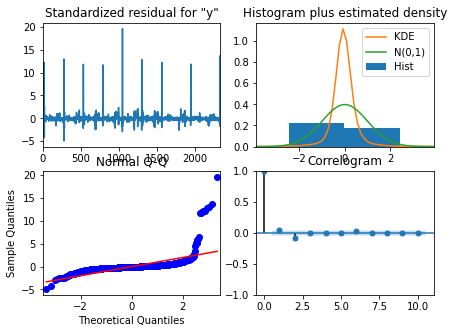

In [29]:
results.plot_diagnostics()
plt.show()

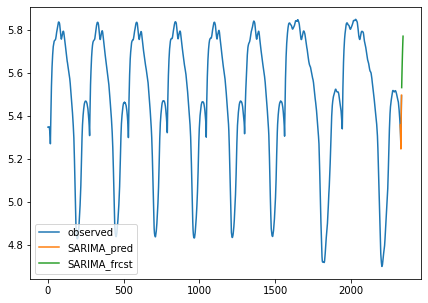

In [48]:
# Create SARIMA mean predict
sarima_pred = results.get_prediction(start=-10)
sarima_mean = sarima_pred.predicted_mean
sarima_frcst = results.get_forecast(steps=10)
sarima_frcst_mean = sarima_frcst.predicted_mean

# Plot mean SARIMA predictions and observed
plt.plot(df_data_log, label='observed')
plt.plot( range(len(df_data_log)-10, len(df_data_log)),sarima_mean, label='SARIMA_pred')
plt.plot(range(len(df_data_log), len(df_data_log)+10),sarima_frcst_mean, label='SARIMA_frcst')
plt.legend()
plt.show()

In [ ]:
corr_matix=df_data.corr()
corr_matix['gyro_yaw'].sort_values(ascending=False)